In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import joblib
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Load the data and drop the url and status columns
train_data = pd.read_csv('training.csv', low_memory=False)
val_data = pd.read_csv('validation.csv', low_memory=False)
test_data = pd.read_csv('test.csv', low_memory=False)

# Extract features and target variable from each dataset
x_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]

x_val = val_data.iloc[:, :-1]
y_val = val_data.iloc[:, -1]

x_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [34]:
# Note: without the scaler, the model could not be trained
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))

# Train the mocel
pipeline.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [35]:
# Validate the model
val_predictions = pipeline.predict(x_val)

val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.9428718476582604


In [36]:
# Test the model
test_predictions = pipeline.predict(x_test)

test_accuracy = accuracy_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)
joblib.dump(pipeline, 'logistic_regression.pkl')

Test Accuracy: 0.954720864419861


['logistic_regression.pkl']

In [37]:
conf_matrix = confusion_matrix(y_test, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1844   90]
 [  86 1867]]


In [38]:
def precision_score(conf_matrix):
    TP = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    return TP / (TP + FP) if (TP + FP) > 0 else 0

In [39]:
def recall_score(conf_matrix):
    TP = conf_matrix[0][0]
    FN = conf_matrix[1][0]
    return TP / (TP + FN) if (TP + FN) > 0 else 0

In [40]:
precision = precision_score(conf_matrix)
recall = recall_score(conf_matrix)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1)

Precision Score: 0.953464322647363
Recall Score: 0.9554404145077721
F1 Score: 0.9544513457556937


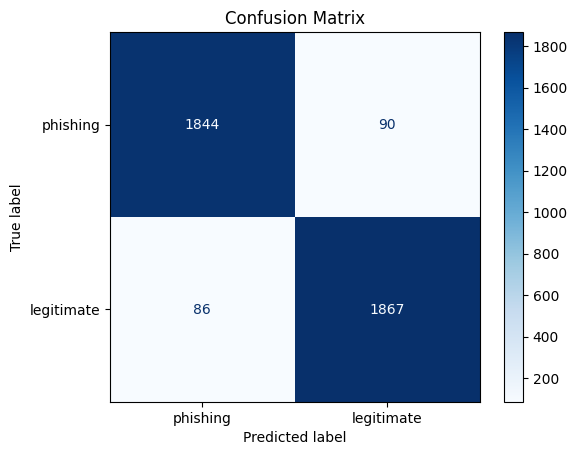

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["phishing", "legitimate"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix")
plt.show()

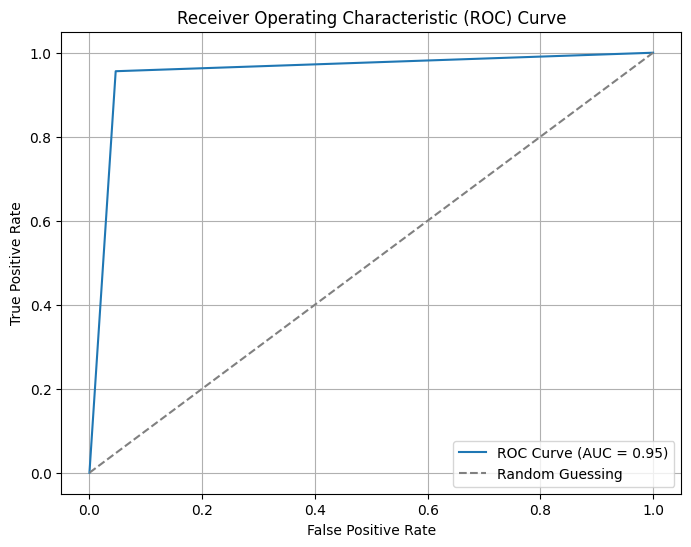

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions)
auc_score = roc_auc_score(y_test, test_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# Define a list of solvers to compare
solvers = ['lbfgs', 'saga', 'liblinear', 'newton-cg']

# Create a dictionary to store cross-validation scores for each solver
solver_scores = {}

# Iterate over each solver
for solver in solvers:
    # Create a pipeline with StandardScaler and logistic regression with the current solver
    pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver=solver))
    
    # Perform cross-validation and store the scores
    scores = cross_val_score(pipeline, x_train, y_train, cv=5)
    solver_scores[solver] = scores

# Print the cross-validation scores for each solver
for solver, scores in solver_scores.items():
    print(f"Solver: {solver}, Mean Accuracy: {scores.mean():.4f}, Std Dev: {scores.std():.4f}")

c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Solver: lbfgs, Mean Accuracy: 0.9472, Std Dev: 0.0025
Solver: saga, Mean Accuracy: 0.9475, Std Dev: 0.0026
Solver: liblinear, Mean Accuracy: 0.9471, Std Dev: 0.0023
Solver: newton-cg, Mean Accuracy: 0.9474, Std Dev: 0.0023


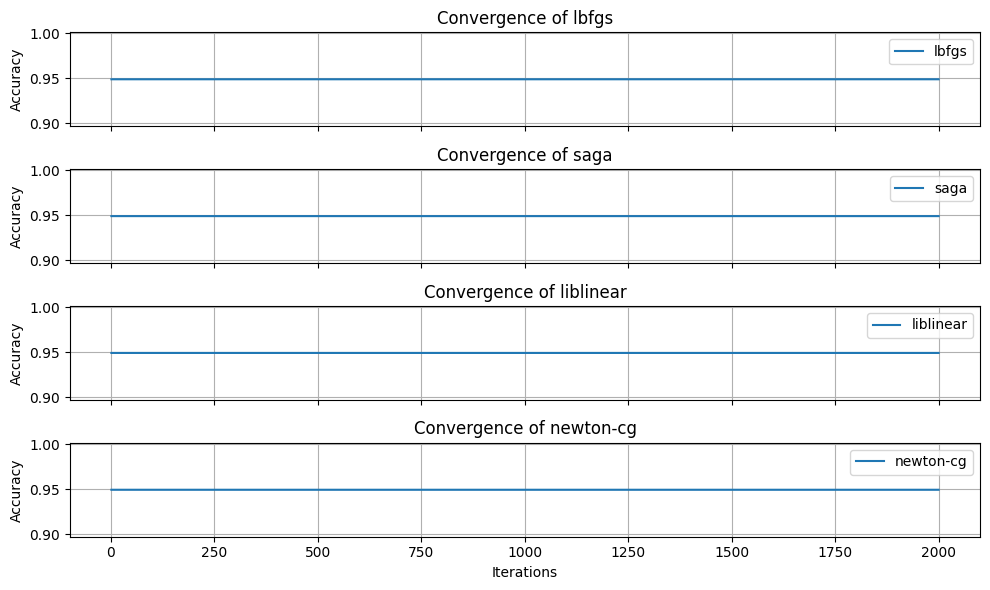

In [53]:
# Define the number of iterations
n_iterations = 2000

# Define a list of solvers to compare
solvers = ['lbfgs', 'saga', 'liblinear', 'newton-cg']

# Create subplots
fig, axes = plt.subplots(len(solvers), figsize=(10, 6), sharex=True)

# Iterate over each solver
for i, solver in enumerate(solvers):
    # Create a pipeline with StandardScaler and logistic regression with the current solver
    pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=n_iterations, solver=solver))
    
    # Fit the model
    pipeline.fit(x_train, y_train)
    
    # Get accuracy scores at each iteration
    accuracy_scores = np.zeros(n_iterations)
    for j in range(n_iterations):
        pipeline.named_steps['logisticregression'].max_iter = j + 1
        accuracy_scores[j] = pipeline.score(x_train, y_train)
    
    # Plot accuracy scores
    axes[i].plot(range(1, n_iterations + 1), accuracy_scores, label=solver)
    axes[i].set_ylabel('Accuracy')
    axes[i].set_title(f'Convergence of {solver}')
    axes[i].grid(True)
    axes[i].legend()

# Set common xlabel
axes[-1].set_xlabel('Iterations')

# Adjust layout
plt.tight_layout()
plt.show()
